# 201611113 천윤한

## pyspark 기본 셋팅

In [1]:
import os
import pyspark

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

## 문제: 2020년 8월 서울시 지하철호선별 역별 승하차 인원 정보.

### 1) DataFrame 생성하고, 스키마는 자동인식하여 출력

**답**

In [2]:
from pyspark.sql.types import *

Subdf = spark.read.format('csv')\
    .option("header",'True')\
    .option("encoding", "utf-8")\
    .load('data/CARD_SUBWAY_MONTH_202008.csv')
Subdf.printSchema()
Subdf.show()

root
 |-- 사용일자: string (nullable = true)
 |-- 노선명: string (nullable = true)
 |-- 역ID: string (nullable = true)
 |-- 역명: string (nullable = true)
 |-- 승차총승객수: string (nullable = true)
 |-- 하차총승객수: string (nullable = true)
 |-- 등록일자: string (nullable = true)

+--------+------+-----------------------+-----+------------+------------+--------+
|사용일자|노선명|                   역ID| 역명|승차총승객수|하차총승객수|등록일자|
+--------+------+-----------------------+-----+------------+------------+--------+
|20200801|중앙선|                   오빈|  249|         239|    20200804|    null|
|20200801|중앙선|                   아신|  467|         595|    20200804|    null|
|20200801|중앙선|                   국수|  520|         598|    20200804|    null|
|20200801| 2호선|                 한양대| 3244|        3022|    20200804|    null|
|20200801| 2호선|       왕십리(성동구청)|11110|        9769|    20200804|    null|
|20200801| 2호선|               상왕십리| 8110|        7289|    20200804|    null|
|20200801| 2호선|                   신당| 8703|        8731|

### 2) 컬럼명을 변경하고, 스키마 출력

**답**

In [3]:
from pyspark.sql.types import *

SubSchema=StructType([
    StructField("사용일자", IntegerType(), True),
    StructField("노션명", StringType(), True),
    StructField("역ID", StringType(), True),
    StructField("역명", IntegerType(), True),
    StructField("승차총승객수", IntegerType(), True),
    StructField("하차총승객수", IntegerType(), True),
    StructField("등록일자", DateType(), True),
])

Subdf = spark.read.format('csv')\
    .option("header",'True')\
    .option("encoding", "utf-8")\
    .schema(SubSchema)\
    .load('data/CARD_SUBWAY_MONTH_202008.csv')

Subdf=Subdf.withColumnRenamed('사용일자','dateUse')
Subdf=Subdf.withColumnRenamed('노션명','line')
Subdf=Subdf.withColumnRenamed('역ID','stationID')
Subdf=Subdf.withColumnRenamed('역명','station')
Subdf=Subdf.withColumnRenamed('승차총승객수','NInPassengers')
Subdf=Subdf.withColumnRenamed('하차총승객수','NOutPassengers')
Subdf=Subdf.withColumnRenamed('등록일자','dateRegi')
Subdf.printSchema()

root
 |-- dateUse: integer (nullable = true)
 |-- line: string (nullable = true)
 |-- stationID: string (nullable = true)
 |-- station: integer (nullable = true)
 |-- NInPassengers: integer (nullable = true)
 |-- NOutPassengers: integer (nullable = true)
 |-- dateRegi: date (nullable = true)



### 3) 노선별 승하차합계가 가장 높은 역을 출력 (모든 노선 출력)

**답**

In [4]:
from pyspark.sql.functions import udf

sum_udf=udf(lambda x,y:x+y, IntegerType())
sumdf = Subdf.withColumn("SumInOut",sum_udf(Subdf.NInPassengers, Subdf.NOutPassengers))
group_data=sumdf.groupBy('stationID').agg({'SumInOut':'sum'})
group_data=group_data.orderBy(group_data['sum(SumInOut)'].desc()).show()

+-----------------------+-------------+
|              stationID|sum(SumInOut)|
+-----------------------+-------------+
|                 서울역|   3152985123|
|                   공덕|   2505752605|
|             고속터미널|   1880476174|
|               홍대입구|   1880332585|
|                종로3가|   1879810855|
|       왕십리(성동구청)|   1879521640|
|동대문역사문화공원(DDP)|   1879365455|
|               김포공항|   1879322273|
|       디지털미디어시티|   1879313860|
|                 신설동|   1879114406|
|         잠실(송파구청)|   1254402829|
|                   선릉|   1253981743|
|                   사당|   1253931497|
|         가산디지털단지|   1253853569|
|                 신도림|   1253740287|
|               건대입구|   1253692916|
|                   합정|   1253533972|
|                   수원|   1253526232|
|                 여의도|   1253524432|
|      교대(법원.검찰청)|   1253518074|
+-----------------------+-------------+
only showing top 20 rows



### 4) 노선별 요일별 승하차인원 합계 (모든 노선 출력)

**답**

In [5]:
sumdf=sumdf.withColumn("date",sumdf.dateUse.substr(7, 2))

def classday(s):
    q=""
    if s=="01" or s=="08" or s=="15" or s=="22" or s=="29":
        q="Saterday"
    elif s=="02" or s=="09" or s=="16" or s=="23" or s=="30":
        q="Sunday"
    elif s=="03" or s=="10" or s=="17" or s=="24" or s=="31":
        q="Monday"
    elif s=="04" or s=="11" or s=="18" or s=="25":
        q="Tuesday"
    elif s=="05" or s=="12" or s=="19" or s=="26":
        q="Wednesday"
    elif s=="06" or s=="13" or s=="20" or s=="27":
        q="Thursday"
    elif s=="07" or s=="14" or s=="21" or s=="28":
        q="Friday"
    else:
        q="no"
    return q
day_udf = udf(classday, StringType())
sumdf=sumdf.withColumn("day", day_udf(sumdf.date))
sumdf.groupBy('line').pivot('day').agg({"SumInOut":"sum"}).show()

+----------+----------+----------+----------+----------+----------+----------+----------+
|      line|    Friday|    Monday|  Saterday|    Sunday|  Thursday|   Tuesday| Wednesday|
+----------+----------+----------+----------+----------+----------+----------+----------+
|    일산선| 808395124|1010437381|1010319451|1010235636| 808383940| 808393127| 808392796|
|    장항선| 484860929| 606069487| 606063946| 606058420| 484854907| 484857571| 484857468|
|    경부선|3152874143|3940824196|3940449561|3940133615|3152768029|3152789327|3152794978|
|우이신설선|1050583774|1313216004|1313167396|1313141053|1050582715|1050586483|1050587942|
|    분당선|2809238836|3435543817|3455281248|3434771069|2788970586|2789009658|2768803828|
|     7호선|4123433410|5153934706|5152897879|5152372864|4123394044|4123436711|4123433745|
|    수인선|1050588760|1313214661|1313171127|1313138823|1050582601|1050584965|1050586007|
|    안산선|1050846248|1313503526|1313393601|1313300973|1050826620|1050840359|1050838751|
|     4호선|2102629179|2627972877|262

### 5) 노선별 요일별 승하차인원 그래프

**답**

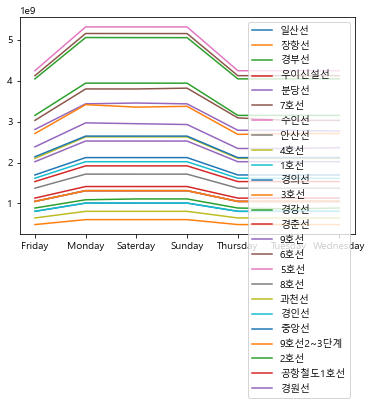

In [6]:
import pandas as pd
import numpy as np

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

sumDay=sumdf.groupBy('line').pivot('day').agg({"SumInOut":"sum"})
pdf=sumDay.toPandas()
my=pdf.drop('line', 1).transpose()
my.columns=["일산선", "장항선", "경부선", "우이신설선", "분당선", "7호선", "수인선", "안산선", "4호선", "1호선", "경의선", "3호선", "경강선", "경춘선", "9호선", "6호선", "5호선", "8호선", "과천선", "경인선", "중앙선","9호선2~3단계", "2호선","공항철도1호선", "경원선"]
my.plot(kind='line')

## 문제: 한국의 코로나바이러스

### 1) DataFrame 생성하고, 자동인식한 스키마를 출력

**답**

In [7]:
virusdf = spark.read.format('csv')\
    .option("header",'True')\
    .option("encoding", "utf-8")\
    .load('data/TimeProvince.csv')
virusdf.printSchema()

root
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- province: string (nullable = true)
 |-- confirmed: string (nullable = true)
 |-- released: string (nullable = true)
 |-- deceased: string (nullable = true)



### 2) 3월의 데이터만 출력

**답**

In [8]:
march_udf = udf(lambda x: x[5:7],StringType())
virusdf.filter(march_udf(virusdf.date)=="03").show()

+----------+----+-----------------+---------+--------+--------+
|      date|time|         province|confirmed|released|deceased|
+----------+----+-----------------+---------+--------+--------+
|2020-03-01|  16|            Seoul|       87|      11|       0|
|2020-03-01|  16|            Busan|       83|       0|       0|
|2020-03-01|  16|            Daegu|     2704|       6|      11|
|2020-03-01|  16|          Incheon|        6|       1|       0|
|2020-03-01|  16|          Gwangju|        9|       2|       0|
|2020-03-01|  16|          Daejeon|       13|       0|       0|
|2020-03-01|  16|            Ulsan|       20|       0|       0|
|2020-03-01|  16|           Sejong|        1|       0|       0|
|2020-03-01|  16|      Gyeonggi-do|       89|       8|       1|
|2020-03-01|  16|       Gangwon-do|       15|       0|       0|
|2020-03-01|  16|Chungcheongbuk-do|       11|       0|       0|
|2020-03-01|  16|Chungcheongnam-do|       68|       0|       0|
|2020-03-01|  16|     Jeollabuk-do|     

### 3) 년x월별 건수

**답**

In [9]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

virusSchema=StructType([
    StructField("date", StringType(), True),
    StructField("time", StringType(), True),
    StructField("province", StringType(), True),
    StructField("confirmed", IntegerType(), True),
    StructField("released", IntegerType(), True),
    StructField("deceased", IntegerType(), True),
])

virusDf = spark.read.format('csv')\
    .option("header",'True')\
    .option("encoding", "utf-8")\
    .schema(virusSchema)\
    .load('data/TimeProvince.csv')

year_udf = udf(lambda x: x[:4],StringType())
month_udf = udf(lambda x: x[5:7],StringType())
ym_virusDf = virusDf.withColumn("year",year_udf(virusDf.date)).withColumn("month",month_udf(virusDf.date))
ym_virusDf.groupBy('year').pivot('month').agg({"confirmed":"sum"}).show()

+----+---+-----+------+------+------+------+
|year| 01|   02|    03|    04|    05|    06|
+----+---+-----+------+------+------+------+
|2020| 41|12153|241505|304109|326967|346403|
+----+---+-----+------+------+------+------+



### 4) 도별 첫 확진자 출현 (모든 도 출력)

**답**

In [10]:
virusDf.groupBy('province').agg({"date":'min'}).show()

+-----------------+----------+
|         province| min(date)|
+-----------------+----------+
|           Sejong|2020-01-20|
|            Ulsan|2020-01-20|
|Chungcheongbuk-do|2020-01-20|
|       Gangwon-do|2020-01-20|
|          Gwangju|2020-01-20|
| Gyeongsangbuk-do|2020-01-20|
|            Daegu|2020-01-20|
| Gyeongsangnam-do|2020-01-20|
|          Incheon|2020-01-20|
|          Jeju-do|2020-01-20|
|      Gyeonggi-do|2020-01-20|
|            Busan|2020-01-20|
|          Daejeon|2020-01-20|
|            Seoul|2020-01-20|
|Chungcheongnam-do|2020-01-20|
|     Jeollabuk-do|2020-01-20|
|     Jeollanam-do|2020-01-20|
+-----------------+----------+



### 5) 도별 누적 확진자 (마지막 일 6월 30일 기준, 모든 도 출력)

**답**

In [11]:
virusDf.groupBy('province').agg({"confirmed":"sum"}).show()

+-----------------+--------------+
|         province|sum(confirmed)|
+-----------------+--------------+
|           Sejong|          5111|
|            Ulsan|          5269|
|Chungcheongbuk-do|          5801|
|       Gangwon-do|          5908|
|          Gwangju|          3359|
| Gyeongsangbuk-do|        161079|
|            Daegu|        807506|
| Gyeongsangnam-do|         13860|
|          Incheon|         16645|
|          Jeju-do|          1449|
|      Gyeonggi-do|         81059|
|            Busan|         16341|
|          Daejeon|          5217|
|            Seoul|         81923|
|Chungcheongnam-do|         16780|
|     Jeollabuk-do|          2108|
|     Jeollanam-do|          1763|
+-----------------+--------------+



## 문제 S-3: 키, 몸무게 상관관계

### 1) DataFrame 생성하고, 스키마를 출력

**답**

In [12]:
wh_Schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("weight", FloatType(), True),
    StructField("height", FloatType(), True)
])
wh_Df = spark\
    .read\
    .options(header='false', inferschema='true', delimiter='\t')\
    .schema(wh_Schema)\
    .csv(os.path.join('data', 'ds_spark_heightweight.txt'))
wh_Df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- weight: float (nullable = true)
 |-- height: float (nullable = true)



### 2) BMI 컬럼 생성

**답**

In [13]:
height_udf = udf(lambda x: x/100, FloatType())
BMI_udf = udf(lambda x,y:x/(y**2),FloatType())
BMI_df = wh_Df.withColumn("BMI",BMI_udf(wh_Df.weight, height_udf(wh_Df.height)))
BMI_df.show()

+---+------+------+---------+
| id|weight|height|      BMI|
+---+------+------+---------+
|  1| 65.78|112.99| 51.52451|
|  2| 71.52|136.49|38.390675|
|  3|  69.4|153.03|29.635094|
|  4| 68.22|142.34|33.671143|
|  5| 67.79| 144.3| 32.55614|
|  6|  68.7| 123.3| 45.18877|
|  7|  69.8|141.49|34.866142|
|  8| 70.01|136.46|37.596664|
|  9|  67.9|112.37|53.773586|
| 10| 66.78|120.67|45.861454|
| 11| 66.49|127.45| 40.93329|
| 12| 67.62|114.14|51.903835|
| 13|  68.3|125.61| 43.28847|
| 14| 67.12|122.46| 44.75726|
| 15| 68.28|116.09|50.664513|
| 16| 71.09| 140.0| 36.27041|
| 17| 66.46| 129.5|39.629704|
| 18| 68.65|142.97|33.585415|
| 19| 71.23| 137.9|37.457127|
| 20| 67.13|124.04|  43.6308|
+---+------+------+---------+
only showing top 20 rows



### 3) weigth와 height의 Zscore 컬럼 생성

**답**

In [14]:
from pyspark.sql import functions as F

wh_Df=wh_Df.withColumn('weightF', wh_Df['weight']).withColumn('heightF', wh_Df['height'])

weightStats = wh_Df.select(
    F.mean('weightF').alias('mean'),
    F.stddev('weightF').alias('std')).collect()
meanWeight = weightStats[0]['mean']
stdWeight = weightStats[0]['std']

heightStats = wh_Df.select(
    F.mean('heightF').alias('mean'),
    F.stddev('heightF').alias('std')).collect()
meanHeight = heightStats[0]['mean']
stdHeight = heightStats[0]['std']

zscoreW_udf = F.udf(lambda x: (x-meanWeight)/stdWeight, FloatType()) 
zscoreH_udf = F.udf(lambda x: (x-meanHeight)/stdHeight, FloatType()) 
wh_Df=wh_Df.withColumn("zscoreW", zscoreW_udf(wh_Df['weightF'])).withColumn("zscoreH", zscoreH_udf(wh_Df['heightF']))
wh_Df.select('id', 'weight', 'height', 'zscoreW', 'zscoreH').show()

+---+------+------+-----------+------------+
| id|weight|height|    zscoreW|     zscoreH|
+---+------+------+-----------+------------+
|  1| 65.78|112.99| -1.2458475|  -1.2298968|
|  2| 71.52|136.49|  1.9011154|  0.59337974|
|  3|  69.4|153.03|  0.7388248|   1.8766551|
|  4| 68.22|142.34| 0.09188773|   1.0472584|
|  5| 67.79| 144.3|-0.14386062|   1.1993278|
|  6|  68.7| 123.3| 0.35504615| -0.42998254|
|  7|  69.8|141.49| 0.95812625|   0.9813108|
|  8| 70.01|136.46|  1.0732585|  0.59105223|
|  9|  67.9|112.37|-0.08355261|  -1.2779998|
| 10| 66.78|120.67| -0.6975959| -0.63403463|
| 11| 66.49|127.45| -0.8565894|-0.108000234|
| 12| 67.62|114.14|-0.23706238|  -1.1406724|
| 13|  68.3|125.61| 0.13574886|  -0.2507586|
| 14| 67.12|122.46|-0.51118815| -0.49515525|
| 15| 68.28|116.09| 0.12478149|  -0.9893796|
| 16| 71.09| 140.0|  1.6653671|   0.8657069|
| 17| 66.46| 129.5| -0.8730362|  0.05105173|
| 18| 68.65|142.97|  0.3276361|    1.096138|
| 19| 71.23| 137.9|  1.7421262|   0.7027754|
| 20| 67.1

### 4) spark에서 위에 계산한 zscore를 사용하여 상관관계 계산

**답**

In [15]:
import numpy as np
import math

wh_P=wh_Df.toPandas()
zscoreW_list=wh_P.zscoreW.tolist()
zscoreH_list=wh_P.zscoreH.tolist()

def pearson(X,Y):
    numer=np.sum(np.array(X)*np.array(Y)) - len(X)*np.mean(X)*np.mean(Y)
    denom1=np.sum(np.array(X)*np.array(X)) - len(X)*np.power(np.mean(X),2)
    denom2=np.sum(np.array(Y)*np.array(Y)) - len(Y)*np.power(np.mean(Y),2)
    denom=np.sqrt(denom1*denom2)
    #print(numer,denom,numer/denom)
    r=1 if denom==0 else numer/denom
    return r

pearson(zscoreW_list, zscoreH_list)

0.5925222361043136

### 5) scipy를 사용하여 상관관계를 계산

**답**

In [16]:
import scipy.stats as stats
stats.pearsonr(zscoreW_list, zscoreH_list)

(0.5925222361043136, 5.808530072641946e-06)